In [79]:
import pandas as pd
import numpy as np
import os
from os import walk
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

#### Image Placement 
original data set from: 
https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip

It is recommended to use the subset of data created from mapping instead as the original image files are big.

Subset Data can be downloaded here: https://drive.google.com/drive/folders/1er7uISXkbiTDv8BZT0J0XH1BRB03vnVv

put the subset data in directory ./Data/test/

Downloade Saved Models from https://github.com/Avi-k-dua/Melanoma_Detection/tree/master/ISIC2018/Saved%20Models and put in directory ./Saved Models/

In [80]:
# set the path with the test images extracted from original
test_path = os.path.normpath('./Data/test/')

# set the path for 'Saved Models'
ensemble_path = os.path.normpath('./Saved Models/')

# Matching 2020 labels with 2018/2019

Download 2020 Training data ground truth here: https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv

Download the List of 425 duplicate images document here: https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_Duplicates.csv

In [11]:
# put csv files of 2020 groud truth and duplicates here
df_2020_train = pd.read_csv('ISIC_2020_Training_GroundTruth.csv')
df_2020_Duplicates = pd.read_csv('ISIC_2020_Training_Duplicates.csv')

In [12]:
remove_dup = list(df_2020_Duplicates['image_name_2'].values)
df_2020_train = df_2020_train[~df_2020_train['image_name'].isin(remove_dup)]

In [13]:
df_2020_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [14]:
df_2020_train = df_2020_train[['image_name','diagnosis']]

In [15]:
df_2020_train.diagnosis.value_counts().rename_axis('unique_values').to_frame('counts')

,counts
unique_values,
unknown,26706
nevus,5191
melanoma,581
seborrheic keratosis,135
lentigo NOS,44
lichenoid keratosis,35
solar lentigo,7
cafe-au-lait macule,1
atypical melanocytic proliferation,1


In [16]:
# excluding diagnosis labels that can not be mapped to 2018 diagnosis
df_2020_labels = df_2020_train[~df_2020_train['diagnosis'].isin(['unknown',
                                                'cafe-au-lait macule',
                                                'atypical melanocytic proliferation'])]

In [17]:
#Performing mapping of 2020 labels to 2018 labels
df_2020_labels = df_2020_labels.replace({
    'diagnosis': {
        'nevus': 'nv',
        'melanoma': 'mel',
        'seborrheic keratosis': 'bkl',
        'lentigo NOS': 'bkl',
        'lichenoid keratosis': 'bkl',
        'solar lentigo': 'bkl'
    }
})

In [18]:
df_2020_labels.diagnosis.value_counts().rename_axis('unique_values').to_frame('counts')

,counts
unique_values,
nv,5191
mel,581
bkl,221


In [19]:
# adding .jpg to image name
def append_ext(fn):
    return fn+".jpg"

df_2020_labels['image_name'] = df_2020_labels['image_name'].apply(append_ext)

In [20]:
df_2020_labels['labels'] = df_2020_labels['diagnosis']
df_2020_labels = df_2020_labels.replace({
    'labels': {
        'akiec': 0,
        'bcc': 1,
        'bkl': 2,
        'df': 3,
        'mel': 4,
        'nv': 5,
        'vasc': 6
    }
})

In [21]:
#saving to csv
df_2020_labels.to_csv (r'df_2020_labels.csv', index = False, header=True)

Run the following code only if using the original data set to be placed in the correct folders

In [ ]:
#Put images in folder called orig and and make a new folder 'Data/test/'

#os.makedirs(f'Data/test')
#for row in df_2020_labels.values:
#        os.rename(f"orig/{row[0]}.jpg", f"Data/test/{row[0]}.jpg")


### Load Ensemble Models

In [27]:
n = 10

reconstructed_ensemble1 = [0]*n
reconstructed_ensemble2 = [0]*n
reconstructed_ensemble3 = [0]*n

for k in range(n):
    reconstructed_ensemble1[k] = keras.models.load_model(os.path.join(ensemble_path , 'Ensemble1', f"Ensemble1_model{k}"))


for k in range(n):
    reconstructed_ensemble2[k] = keras.models.load_model(os.path.join(ensemble_path , 'Ensemble2', f"Ensemble2_model{k}"))


for k in range(n):
    reconstructed_ensemble3[k] = keras.models.load_model(os.path.join(ensemble_path , 'Ensemble3', f"Ensemble3_model{k}"))

2022-03-24 19:52:44.199147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 19:52:44.215042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 19:52:44.219467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


### Function to predict an image

In [81]:
def classify(img_path,ensemble = 1):
    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = img_array /255

    img_batch = np.expand_dims(img_array, axis=0)
    
    results = np.zeros( (1,7) ) 
    n = 10

    if ensemble == 1:
        for j in range(n):
            results = results + reconstructed_ensemble1[j].predict(img_batch)
    elif ensemble == 2:
        for j in range(n):
            results = results + reconstructed_ensemble2[j].predict(img_batch)
    else:
        for j in range(n):
            results = results + reconstructed_ensemble3[j].predict(img_batch)

    # Performing Max Voting
    results = np.argmax(results,axis = 1)

    return results
    

#### Getting image path for each images

In [23]:

test_img_path = []
for i in df_2020_labels.image_name:
    test_img_path.extend([os.path.join(test_path, i)])
y_label = list(df_2020_labels.labels)

If you want an equal size of each class for prediction you can run the following
###### __
else, you can skip to 'Predict all images in the 3 classes' below

In [60]:
# sample 150 from each class
sample_size = 150
sample_df = df_2020_labels.groupby("diagnosis").sample(n=sample_size, random_state=123)

In [61]:
test_img_path_subset = []
for i in sample_df.image_name:
    test_img_path_subset.extend([os.path.join(test_path, i)])
y_label_subset = list(sample_df.labels)

In [62]:
y_pred1_sub = []
for x in test_img_path_subset:
  y_pred1_sub.extend(classify(x,1))
print("ensemble 1")
print(confusion_matrix(y_label_subset,y_pred1_sub))
print(classification_report(y_label_subset,y_pred1_sub))

ensemble 1
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  9  17   8   4   6 106]
 [  0   0   0   0   0   0]
 [  4  10   2   1  14 119]
 [  0   1   1   0   2 146]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.73      0.05      0.10       150
           3       0.00      0.00      0.00         0
           4       0.64      0.09      0.16       150
           5       0.39      0.97      0.56       150

    accuracy                           0.37       450
   macro avg       0.29      0.19      0.14       450
weighted avg       0.59      0.37      0.27       450



C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred2_sub = []
for x in test_img_path_subset:
  y_pred2_sub.extend(classify(x,2))
print("ensemble 2")
print(confusion_matrix(y_label_subset,y_pred2_sub))
print(classification_report(y_label_subset,y_pred2_sub))

ensemble 2
[[ 98  52   0   0]
 [  0   0   0   0]
 [ 54  96   0   0]
 [ 36 114   0   0]]
              precision    recall  f1-score   support

           2       0.52      0.65      0.58       150
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00       150

    accuracy                           0.22       450
   macro avg       0.13      0.16      0.14       450
weighted avg       0.17      0.22      0.19       450



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
y_pred3_sub = []
for x in test_img_path_subset:
  y_pred3_sub.extend(classify(x,3))
print("ensemble 3")
print(confusion_matrix(y_label_subset,y_pred3_sub))
print(classification_report(y_label_subset,y_pred3_sub))

[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 16  21  20  11  10  72   0]
 [  0   0   0   0   0   0   0]
 [ 11  10   9   2  16 101   1]
 [  2   2   4   0   1 141   0]
 [  0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.61      0.13      0.22       150
           3       0.00      0.00      0.00         0
           4       0.59      0.11      0.18       150
           5       0.45      0.94      0.61       150
           6       0.00      0.00      0.00         0

    accuracy                           0.39       450
   macro avg       0.24      0.17      0.14       450
weighted avg       0.55      0.39      0.34       450



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Predict all images in the 3 classes

Prediction result of 2020 images using 2018 ensemble 1

In [ ]:
%%time
y_pred1 = []
for x in test_img_path:
    y_pred1.extend(classify(x,1))

In [82]:
print("ensemble 1")
print(confusion_matrix(y_label,y_pred1))
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(y_label,y_pred1, target_names=target_names))

ensemble 1
[[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [  13   25   11    7    7  157    1]
 [   0    0    0    0    0    0    0]
 [  10   32   17    2   69  449    2]
 [  14   58   49   22   59 4976   13]
 [   0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.14      0.05      0.07       221
          df       0.00      0.00      0.00         0
         mel       0.51      0.12      0.19       581
          nv       0.89      0.96      0.92      5191
        vasc       0.00      0.00      0.00         0

    accuracy                           0.84      5993
   macro avg       0.22      0.16      0.17      5993
weighted avg       0.83      0.84      0.82      5993



/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction result of 2020 images using 2018 ensemble 2

In [30]:
%%time
y_pred2 = []
for x in test_img_path:
    y_pred2.extend(classify(x,2))
print("ensemble 2")
print(confusion_matrix(y_label,y_pred2))
print(classification_report(y_label,y_pred2))

2022-03-24 20:34:21.900441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.287292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.386411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.479102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.574410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.662768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-24 20:34:22.764206: I tensorflow/core/grappler/optimizers/cust

ensemble 2
[[ 141   80    0    0]
 [   0    0    0    0]
 [ 205  376    0    0]
 [1250 3941    0    0]]
              precision    recall  f1-score   support

           2       0.09      0.64      0.16       221
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00       581
           5       0.00      0.00      0.00      5191

    accuracy                           0.02      5993
   macro avg       0.02      0.16      0.04      5993
weighted avg       0.00      0.02      0.01      5993

CPU times: user 30min 45s, sys: 4min 53s, total: 35min 38s
Wall time: 33min 43s


/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoliang/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

Prediction result of 2020 images using 2018 ensemble 3

In [ ]:
y_pred3 = []
for x in test_img_path:
  y_pred3.extend(classify(x,3))
print("ensemble 3")
print(confusion_matrix(y_label,y_pred3))
print(classification_report(y_label,y_pred3))

ensemble 3
[[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [  27   27   28   16   13  110    0]
 [   0    0    0    0    0    0    0]
 [  31   34   43   10   78  382    3]
 [  50   67   79   31   93 4856   15]
 [   0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.19      0.13      0.15       221
           3       0.00      0.00      0.00         0
           4       0.42      0.13      0.20       581
           5       0.91      0.94      0.92      5191
           6       0.00      0.00      0.00         0

    accuracy                           0.83      5993
   macro avg       0.22      0.17      0.18      5993
weighted avg       0.83      0.83      0.82      5993



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using only mel and nv

In [76]:
df_2020_nv_mel = df_2020_labels[df_2020_labels.diagnosis.isin(['mel','nv'])]
df_2020_nv_mel

,image_name,diagnosis,labels
2,ISIC_0052212.jpg,nv,5
12,ISIC_0076995.jpg,nv,5
26,ISIC_0084086.jpg,nv,5
27,ISIC_0084270.jpg,nv,5
28,ISIC_0084395.jpg,nv,5
...,...,...,...
33108,ISIC_9995691.jpg,nv,5
33113,ISIC_9997614.jpg,nv,5
33117,ISIC_9998682.jpg,mel,4
33118,ISIC_9998937.jpg,nv,5


In [77]:
nv_mel_img_path = []
for i in df_2020_nv_mel.image_name:
    nv_mel_img_path.extend([os.path.join(test_path, i)])
y_label_nv_mel = list(df_2020_nv_mel.labels)

In [81]:
%%time
y_pred1_nv_mel = []
for x in nv_mel_img_path:
    y_pred1_nv_mel.extend(classify(x,1))
print("ensemble 1 only nv and mel")
print(confusion_matrix(y_label_nv_mel,y_pred1_nv_mel))
print(classification_report(y_label_nv_mel,y_pred1_nv_mel))

ensemble 1 only nv and mel
[[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [  10   32   17    2   69  449    2]
 [  14   58   49   22   59 4976   13]
 [   0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.54      0.12      0.19       581
           5       0.92      0.96      0.94      5191
           6       0.00      0.00      0.00         0

    accuracy                           0.87      5772
   macro avg       0.21      0.15      0.16      5772
weighted avg       0.88      0.87      0.86      5772

Wall time: 39min 36s


C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
%%time
y_pred2_nv_mel = []
for x in nv_mel_img_path:
    y_pred2_nv_mel.extend(classify(x,2))
print("ensemble 2 only nv and mel")
print(confusion_matrix(y_label_nv_mel,y_pred2_nv_mel))
print(classification_report(y_label_nv_mel,y_pred2_nv_mel))

ensemble 2 only nv and mel
[[   0    0    0    0]
 [   0    0    0    0]
 [ 205  376    0    0]
 [1250 3941    0    0]]
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00     581.0
           5       0.00      0.00      0.00    5191.0

    accuracy                           0.00    5772.0
   macro avg       0.00      0.00      0.00    5772.0
weighted avg       0.00      0.00      0.00    5772.0

Wall time: 40min 22s


C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [79]:
%%time
y_pred3_nv_mel = []
for x in nv_mel_img_path:
    y_pred3_nv_mel.extend(classify(x,3))
print("ensemble 3 nv and mel")
print(confusion_matrix(y_label_nv_mel,y_pred3_nv_mel))
print(classification_report(y_label_nv_mel,y_pred3_nv_mel))

ensemble 3
[[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [  31   34   43   10   78  382    3]
 [  50   67   79   31   93 4856   15]
 [   0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.46      0.13      0.21       581
           5       0.93      0.94      0.93      5191
           6       0.00      0.00      0.00         0

    accuracy                           0.85      5772
   macro avg       0.20      0.15      0.16      5772
weighted avg       0.88      0.85      0.86      5772

Wall time: 40min 26s


C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19597\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2020 Data Prediction result images samples

In [43]:
df_2020_labels['predictions1'] = y_pred1

In [72]:
nv_false1 = df_2020_labels[(df_2020_labels.diagnosis == 'nv') &
              (df_2020_labels.labels != df_2020_labels.predictions1)].reset_index()
nv_true1 = df_2020_labels[(df_2020_labels.diagnosis == 'nv') &
              (df_2020_labels.labels == df_2020_labels.predictions1)].reset_index()

mel_false1 = df_2020_labels[(df_2020_labels.diagnosis == 'mel') &
              (df_2020_labels.labels != df_2020_labels.predictions1)].reset_index()
mel_true1 = df_2020_labels[(df_2020_labels.diagnosis == 'mel') &
              (df_2020_labels.labels == df_2020_labels.predictions1)].reset_index()

bkl_false1 = df_2020_labels[(df_2020_labels.diagnosis == 'bkl') &
              (df_2020_labels.labels != df_2020_labels.predictions1)].reset_index()
bkl_true1 = df_2020_labels[(df_2020_labels.diagnosis == 'bkl') &
              (df_2020_labels.labels == df_2020_labels.predictions1)].reset_index()

incorrect predictions: Nevus images (ensemble 1) sample


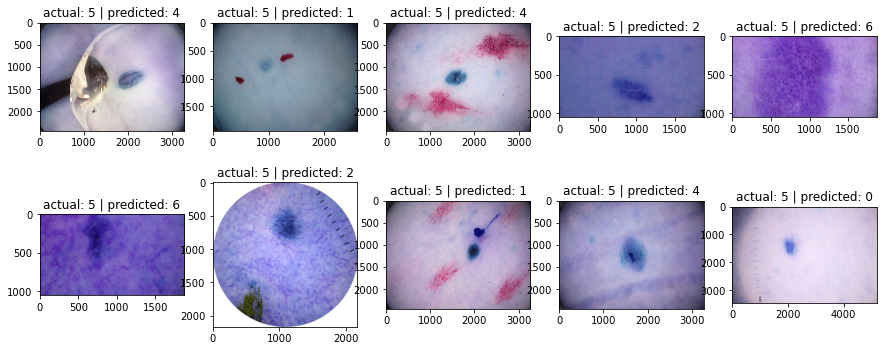

In [71]:
print("incorrect predictions: Nevus images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,nv_false1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(nv_false1.labels[i]) + " | predicted: " + str(nv_false1.predictions1[i])) 
    plt.imshow(img)
plt.show()

correct predictions: Nevus images (ensemble 1) sample


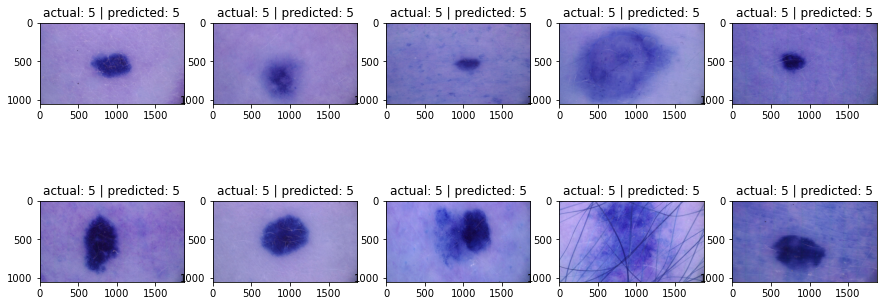

In [70]:
print("correct predictions: Nevus images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,nv_true1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(nv_true1.labels[i]) + " | predicted: " + str(nv_true1.predictions1[i])) 
    plt.imshow(img)
plt.show()

incorrect predictions: Melanoma images (ensemble 1) sample


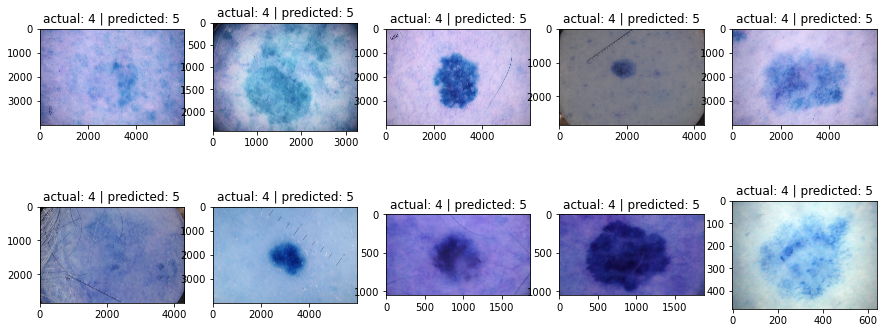

In [73]:
print("incorrect predictions: Melanoma images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,mel_false1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(mel_false1.labels[i]) + " | predicted: " + str(mel_false1.predictions1[i])) 
    plt.imshow(img)
plt.show()

correct predictions: Melanoma images (ensemble 1) sample


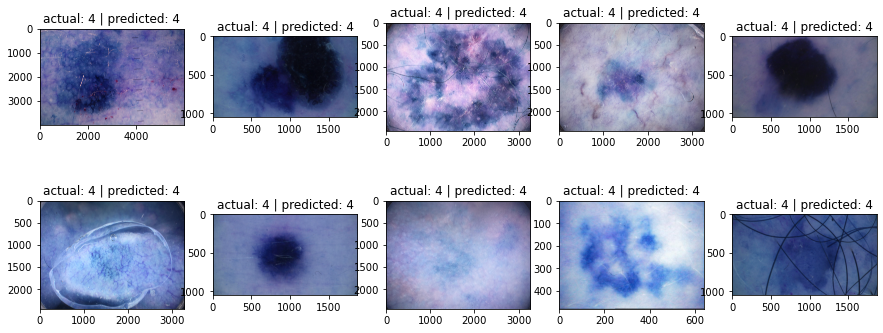

In [74]:
print("correct predictions: Melanoma images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,mel_true1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(mel_true1.labels[i]) + " | predicted: " + str(mel_true1.predictions1[i])) 
    plt.imshow(img)
plt.show()

incorrect predictions: BKL images (ensemble 1) sample


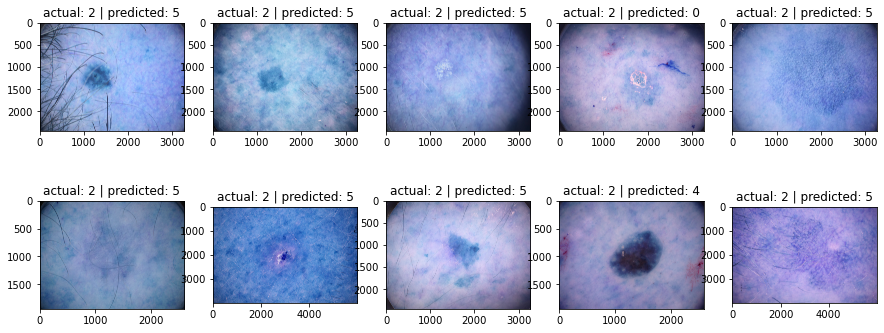

In [75]:
print("incorrect predictions: BKL images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,bkl_false1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(bkl_false1.labels[i]) + " | predicted: " + str(bkl_false1.predictions1[i])) 
    plt.imshow(img)
plt.show()

correct predictions: BKL images (ensemble 1) sample


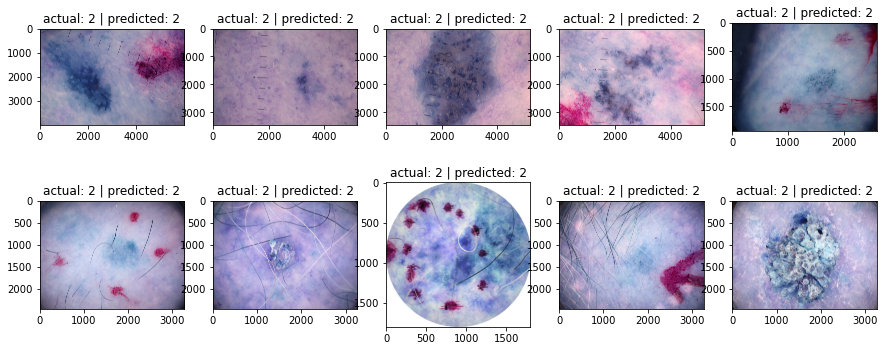

In [76]:
print("correct predictions: BKL images (ensemble 1) sample")
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
ax = []
for i in range(columns*rows):
    img = cv2.imread(os.path.join(test_path,bkl_true1.image_name[i]))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("actual: "+str(bkl_true1.labels[i]) + " | predicted: " + str(bkl_true1.predictions1[i])) 
    plt.imshow(img)
plt.show()